<a href="https://colab.research.google.com/github/nick01as/AI-ML-starter-kit/blob/nick01as-patch-1/ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TritonHacks 2025: Introduction to AI/ML Starter Kit Part II: Machine Learning (ML)

Welcome to the Intro to AI/ML Starter Kit for TritonHacks 2025! This is the second of two notebooks in this repo, and it focuses on creating ML models.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pandas as pd

In [2]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/AI-ML-StarterKit/healthcare-dataset-stroke-data.csv')
df.head()

Mounted at /content/drive


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
# One-hot encoding of Work

one_hot = pd.get_dummies(
    df,
    columns=['work_type', 'gender', 'smoking_status', 'Residence_type', 'ever_married'],
    prefix=['work', 'gender', 'smoking', 'Residence', 'marriage']
)
df = one_hot
df = df.fillna(df.median(numeric_only=True))

In [4]:
# Define X and y

X = df.drop(["stroke", "id"], axis = 1)
y = df["stroke"]

In [28]:
# Train-Test Spliting

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 0)

In [6]:
# Scaling dominant numeric features

to_scale = ['age', 'avg_glucose_level', 'bmi']
not_scaled = [col for col in X.columns if col not in to_scale]

scaler = StandardScaler()
scaled_part = scaler.fit_transform(X[to_scale])
scaled_df = pd.DataFrame(scaled_part, columns=to_scale)

X_final = pd.concat([scaled_df, X[not_scaled].reset_index(drop=True)], axis=1)

In [7]:
# KNN Classification

KNN = KNeighborsClassifier(n_neighbors = 9)
KNN.fit(X_train, y_train)
y_predicted = KNN.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
print(acc)

0.9461839530332681


In [10]:
from sklearn.metrics import precision_recall_curve, auc
from matplotlib import pyplot as plt
def precision_recall_score(X_data, y_data, model):
  y_scores = model.predict_proba(X_test)[:, 1]
  precision, recall, thresholds = precision_recall_curve(y_data, y_scores)
  auc_score = auc(recall, precision)

  # Plot precision-recall curve
  plt.figure(figsize=(8, 6))
  plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_score:.2f})')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve')
  plt.legend()
  plt.show()

  return precision, recall, auc_score

In [38]:
from sklearn.tree import DecisionTreeClassifier as DT

dt = DT(max_depth = 5, random_state = 0, class_weight = {0:1, 1: 0.2})
dt.fit(X_train, y_train)
accuracy = dt.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.949119373776908


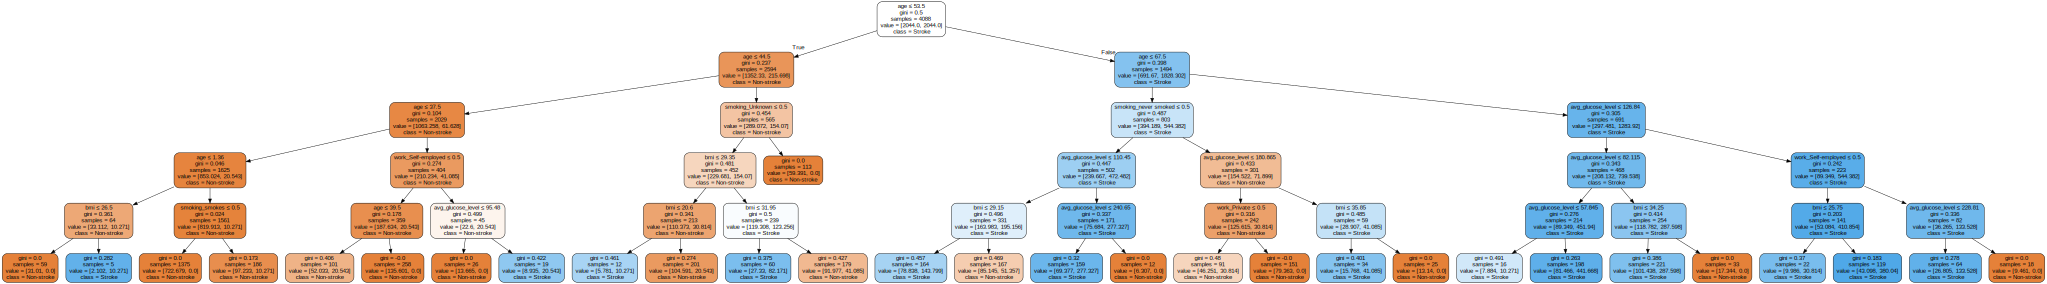

In [30]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(dt, out_file=None, feature_names=X.columns, class_names=['Non-stroke', 'Stroke'], filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph

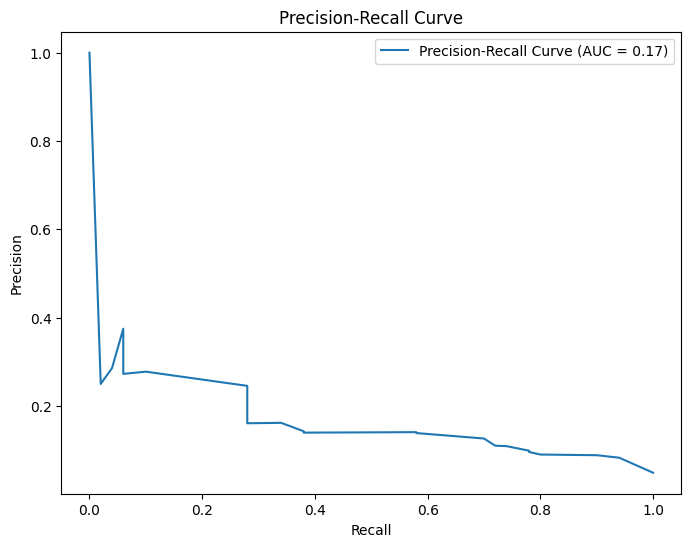

AUC Score: 0.1692056090125942


In [39]:
precision, recall, auc_score = precision_recall_score(X_test, y_test, dt)
print(f'AUC Score: {auc_score}')

Accuracy: 0.7416829745596869


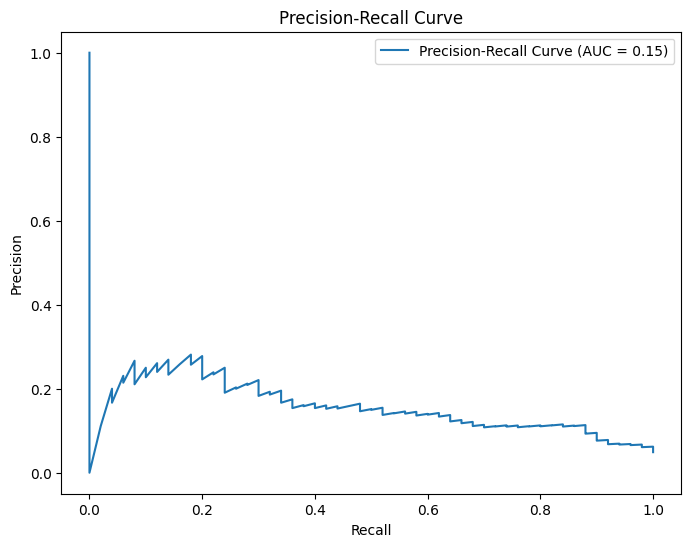

AUC Score: 0.15369282145154253


In [32]:
from sklearn.ensemble import RandomForestClassifier as RF

rf = RF(n_estimators = 100, max_depth = 5, random_state = 0, class_weight = 'balanced')
rf.fit(X_train, y_train)
accuracy = rf.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

precision, recall, auc_score = precision_recall_score(X_test, y_test, rf)
print(f'AUC Score: {auc_score}')

0.9461839530332681


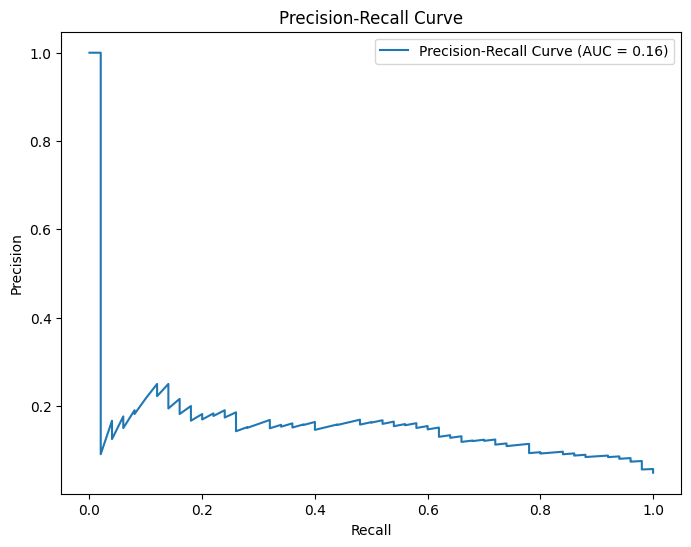

AUC Score: 0.15910771315854952


In [33]:
mlp = MLPClassifier(hidden_layer_sizes = (256, 128), max_iter = 1000, random_state = 0)
mlp.fit(X_train, y_train)
y_predicted = mlp.predict(X_test)
acc = accuracy_score(y_predicted, y_test)
print(acc)

precision, recall, auc_score = precision_recall_score(X_test, y_test, mlp)
print(f'AUC Score: {auc_score}')

In [ ]:
from sklearn.model_selection import KFold, cross_val_score

mlp = MLPClassifier(hidden_layer_sizes = (64, 32), max_iter = 1000, random_state = 0)
k_folds = KFold(n_splits = 5, shuffle = True, random_state = 0)
scores = cross_val_score(mlp, X, y, cv = k_folds)
print(scores, scores.mean())

[0.94716243 0.95205479 0.95205479 0.95303327 0.94520548] 0.9499021526418787
